In [1]:


import torch

from torch.utils.data import Dataset, DataLoader



from torchvision import transforms as T, utils

import matplotlib.pyplot as plt
from PIL import Image




import time
#ab diffusion related imports
#from AB_diffusion.user_hints import RandomHintGenerator, get_color_hints 
from AB_diffusion.color_handling import de_normalize_lab, normalize_lab,plotMinMax
from AB_diffusion.ab_denoising_diffusion_pytorch import ABUnet, ABGaussianDiffusion

from AB_diffusion.ab_trainer import ABDataset
from AB_diffusion.user_hints import RandomHintGenerator

from kornia.color import rgb_to_lab, lab_to_rgb
from datasets import load_from_disk,load_dataset
#from ab_classifier_free_guidance import *


import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geom

import torchvision.transforms as transforms


In [2]:
import os
os.environ['HF_DATASETS_CACHE'] = "/Home/siv32/eve036/.cache/huggingface/datasets"
from datasets import load_dataset
dataset = load_dataset("imagenet-1k", split="validation")

In [3]:
device = torch.device(0 if torch.cuda.is_available() else "cpu")
print(device)
print("Selected GPU:", torch.cuda.get_device_name(device))
#check wicj gpu is selected


#dataset = ABDataset(load_dataset("imagenet-1k",split="validation"),image_size=256)
dataset = ABDataset(dataset,image_size=256)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, pin_memory = True,num_workers=8)

cuda:0
Selected GPU: A100-SXM4-80GB


In [4]:
# Measure the start time
import time
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a dummy batch of 1000 images of size 64x64, with 3 channels (L, A, B)
num_images = 10
H, W = 64, 64
dummy_images = torch.rand((num_images, 2, H, W), device=device)

# Initialize the HintGenerator
hintgen = RandomHintGenerator(hint_size_range=[1, 9], p=1/8, reveal_all_rate=0., mu_factor=2, sigma_factor=4,return_n_hints = False, fixed_hint_size = 2,uniform_hint_range = [1,2,5,10,50,100],uniform_hint_loc = True)

# Measure the start time
start_time = time.time()

# Generate hints using the AB channels
hints = hintgen.generate_hints(dummy_images)

# Measure the end time
end_time = time.time()

# Compute and print the elapsed time
elapsed_time = end_time - start_time
print("Elapsed Time:", elapsed_time, "seconds")

Elapsed Time: 0.02074289321899414 seconds


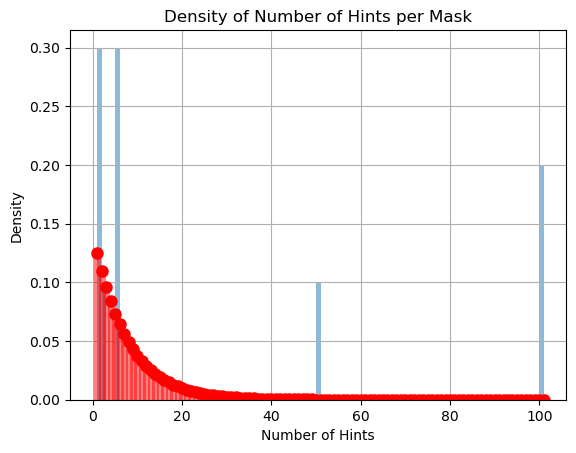

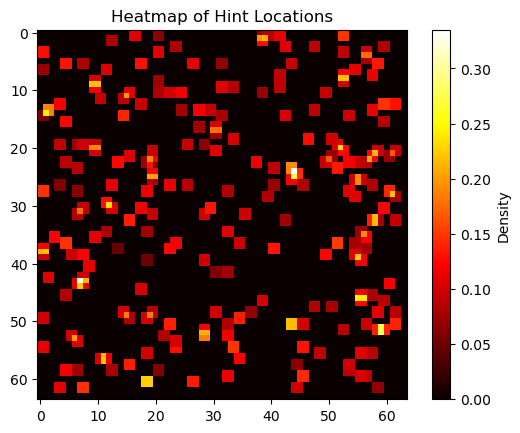

In [5]:


# 1. Collect the number of hints for each image in the batch
# (Assuming the _sample_num_hints method is accessible; if not, it may need to be called within the generate_hints method)
num_hints_list = [hintgen._sample_num_hints() for _ in range(num_images)]

# 2. Plot the actual distribution of the number of hints
plt.hist(num_hints_list, bins=np.arange(0, max(num_hints_list)+2), density=True, alpha=0.5, label='Actual Distribution')

# 3. Plot the theoretical geometric distribution
p = hintgen.p  # Probability parameter for the geometric distribution
x = np.arange(1, max(num_hints_list)+2)
pmf = geom.pmf(x, p)
plt.plot(x, pmf, 'ro', ms=8, label='Theoretical Geometric Distribution')
plt.vlines(x, 0, pmf, colors='r', lw=5, alpha=0.5)

# Plot settings
plt.title('Density of Number of Hints per Mask')
plt.xlabel('Number of Hints')
plt.ylabel('Density')
plt.grid(True)
plt.show()



heatmap = torch.zeros((H, W), device=device)
for hint in hints:
    heatmap += hint.sum(dim=0)

# Normalize the heatmap
heatmap /= num_images

# Move the heatmap to CPU and convert to numpy array for plotting
heatmap = heatmap.cpu().numpy()

# Plot the heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title('Heatmap of Hint Locations')
plt.colorbar(label='Density')
plt.show()

In [ ]:
device = torch.device(0 if torch.cuda.is_available() else "cpu")
print(device)
print("Selected GPU:", torch.cuda.get_device_name(device))
#check wicj gpu is selected
torch.cuda.set_device(device)

test_folder = "./data/sem images/val"

#dataset = ABDataset(load_dataset("imagenet-1k",split="validation"),image_size=256)
dataset = ABDataset(load_dataset("imagefolder", data_dir=test_folder)["train"],image_size=256)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, pin_memory = True,num_workers=8)

cuda:0
Selected GPU: A100-SXM4-80GB


Resolving data files:   0%|          | 0/99 [00:00<?, ?it/s]

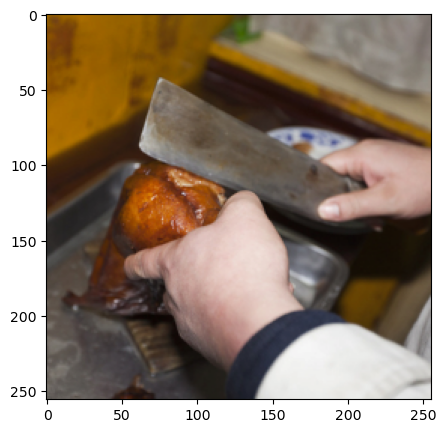

In [ ]:
imgL, imgAB = next(iter(dataloader))

#cat them together, convert to rgb and display
imgLAB = torch.cat((imgL,imgAB),dim=1)
imgRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(imgLAB).squeeze(0).detach().cpu()
            )
        )


# display imgRGB in notebook, i want it to be atleast 7 inches wide
plt.figure(figsize=(5,5))
plt.imshow(imgRGB)
plt.show()


In [ ]:
print(imgAB.shape)
hintgen = HintGenerator()
hints = hintgen.generate_hints(imgAB)
print(hints.shape)

img_w_hints = transforms.ToPILImage()(
        lab_to_rgb(
            de_normalize_lab(torch.cat((imgL, hints), 1)).squeeze(0).detach().cpu()
        )
    )
plt.figure(figsize=(5,5))
plt.imshow(img_w_hints)
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(imgRGB)
plt.show()

torch.Size([1, 2, 256, 256])


NameError: name 'HintGenerator' is not defined